In [1]:
using Distributions
using LinearAlgebra
using StatsPlots
using Random
Random.seed!(1320)
gr()

Plots.GRBackend()

In [2]:
function compute_approx_likelihoods(true_p1s, ns)
    # Computing ABC posterior estimates
    success_numbers = rand.(Binomial.(ns, true_p1s))
    
    return success_numbers./ns
end

function compute_approx_posterior(true_p1s, ns)
    likelihoods = compute_approx_likelihoods(true_p1s, ns)
    if sum(likelihoods) == 0
        print(true_p1s, ns)
    end
    return normalize(likelihoods, 1)
end

function compute_exact_posterior(true_p1s)
    return normalize(true_p1s, 1)
end

compute_exact_posterior (generic function with 1 method)

In [3]:


function compute_posterior_error(approx_posterior, true_posterior; target_f = x -> x)
    n_thetas = length(approx_posterior)

    return sum([(approx_posterior - true_posterior)[i]*target_f(i) for i in 1:n_thetas])
end

function posterior_errors(true_p1s, ns, num_trials; target_f = x -> x)
    return [compute_posterior_error(compute_approx_posterior(true_p1s, ns), compute_exact_posterior(true_p1s); target_f = target_f)
            for i in 1:num_trials]
end

posterior_errors (generic function with 1 method)

In [4]:
function expected_ess(true_p1s, ns; prior = nothing)
    # expected effective sample size
    if prior == nothing
        prior = normalize(ones(length(true_p1s)), 1)
    end
    
    expected_accepted = true_p1s.*ns   
    weights_sum = dot(true_p1s, prior)*sum(ns)    
    squared_weights_sum = sum((prior.^2).*true_p1s./ns)*sum(ns)^2    
    return weights_sum^2 / squared_weights_sum
end
    

expected_ess (generic function with 1 method)

In [5]:
function squared_error_statistics(true_p1s, ns, num_trials = 100; target_f = x -> x)
    raw_errors = posterior_errors(true_p1s, ns, num_trials; target_f = target_f)
    if target_f == :KL
        errors = raw_errors
    else
        errors = norm.(raw_errors).^2
    end
    errors = errors[.~ isnan.(errors)]
    return mean(errors), quantile(errors, 0.25),quantile(errors, 0.75)
end

function predicted_squared_error(true_p1s, ns)
    # assuming two hypothesis, test function difference is 1
    @assert length(true_p1s) == 2
    
    factor_1 = true_p1s[2]*(1 - true_p1s[1])/ns[1] + true_p1s[1]*(1 - true_p1s[2])/ns[2]
    factor_2 = prod(true_p1s)/sum(true_p1s)^4
    return factor_1*factor_2
end

predicted_squared_error (generic function with 1 method)

In [6]:
function all_squared_errors(true_p1s, ns_array; num_trials = 100, target_f = x -> x)
    if length(true_p1s) == 2
        return hcat([vcat(squared_error_statistics(true_p1s, ns, num_trials; target_f = target_f)...,
                            predicted_squared_error(true_p1s, ns)) for ns in ns_array]...)
    else
        return hcat([vcat(squared_error_statistics(true_p1s, ns, num_trials; target_f = target_f)...) for ns in ns_array]...)
    end
end



all_squared_errors (generic function with 1 method)

In [7]:


function compute_posterior_mean(true_p1s; target_f = x -> x)
    # assuming uniform prior
    n_thetas = length(true_p1s)
    posterior = compute_exact_posterior(true_p1s)
    return sum([posterior[i]*target_f(i) for i in 1:n_thetas])
end

function optimal_ni_fractions(true_p1s; target_f = x -> x)
    # assuming uniform prior
    n_thetas = length(true_p1s)
    posterior_mean = compute_posterior_mean(true_p1s, target_f = target_f)
    
    f_deviations = norm.([target_f(i) - posterior_mean for i in 1:n_thetas])
    relative_proportions = sqrt.(true_p1s.*(1 .- true_p1s)).*f_deviations
    return relative_proportions/sum(relative_proportions)
end
    

optimal_ni_fractions (generic function with 1 method)

In [8]:
function posterior_target(theta, n_thetas)
    v = zeros(n_thetas)
    v[theta] = 1
    return v
end

posterior_target (generic function with 1 method)

In [9]:
function relative_ns_to_ns(total_n, relative_ns)
    relative_ns = relative_ns./sum(relative_ns)
    return Int64.(round.(total_n .* relative_ns)) .+ 1
end

relative_ns_to_ns (generic function with 1 method)

In [10]:
thetas = -5:0.1:5
true_p1s = exp.(-(thetas.^2)/2);

In [11]:
function relative_ns(true_p1s, name)
    if name == "Posterior"
        return true_p1s
    elseif name == "Prior"
        return ones(size(true_p1s))
    elseif name == "Optimized for ESS"
        return sqrt.(true_p1s)
    elseif name == "Optimized for unnormalized"
        return sqrt.(true_p1s .* (1 .- true_p1s))
    elseif name == "Optimized for log-likelihood"
        return true_p1s.^(-1)
    end
end

function make_symbol(name)
    if name == "Posterior"
        return :square
    elseif name == "Prior"
        return :diamond
    elseif name == "Optimized for ESS"
        return :utriangle
    elseif name == "Optimized for unnormalized"
        return :dtriangle
    elseif name == "Optimized for log-likelihood"
        return :star
    else
        return :circle
    end
end

function make_style(name)
    if name == "Posterior"
        return :dashdotdot
    elseif name == "Prior"
        return :dash
    elseif name == "Optimized for ESS"
        return :dashdot
    elseif name == "Optimized for unnormalized"
        return :dot
    elseif name == "Optimized for log-likelihood"
        return :dot
    else
        return :solid
    end
end

legendfontsize = 12
tickfontsize = 12
labelfontsize = 16

function make_mse_plot_pair(target_f, true_p1s, proposal_names; ns_scale = 10 .^(3:8), num_trials = 100, marker_size = 8, alpha = 1)
    optimized_relative_ns = optimal_ni_fractions(true_p1s, target_f = target_f)
    
    optimized_ns_array = [relative_ns_to_ns(n, optimized_relative_ns) for n in ns_scale]
    errors = Dict("Optimized for MSE" => all_squared_errors(true_p1s,
                                        optimized_ns_array,
                                        num_trials = num_trials,
                                        target_f = target_f))
    
    ns_arrays = Dict()
    for name in proposal_names
        proposal_relative_ns = relative_ns(true_p1s, name)
        ns_arrays[name] = [relative_ns_to_ns(n, proposal_relative_ns) for n in ns_scale]
        errors[name] = all_squared_errors(true_p1s, ns_arrays[name], num_trials = num_trials, target_f = target_f)
    end
    
    absolute_error_plot = scatter([sum(ns) for ns in optimized_ns_array], errors["Optimized for MSE"][1,:],
        yscale = :log10,
        xscale = :log10,
        label = "Optimized for MSE",
        xlabel = "Sample size",
        ylabel = "Mean squared error",
        legend = :bottomleft,
        framestyle = :box,
        m = marker_size,
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
        alpha = alpha,
    )
    
    for name in proposal_names
        scatter!([sum(ns) for ns in ns_arrays[name]], errors[name][1,:],
            label = name,
            m = (make_symbol(name), marker_size),
            alpha = alpha,
        )
    end
    
    
    relative_error_plot = plot([sum(ns) for ns in optimized_ns_array], ones(length(optimized_ns_array)),
        ylim = [1, :auto],
        yscale = :identity,
        xscale = :log10,
        framestyle = :box,
        legend = :topleft,
        label = "Optimized for MSE",
        xlabel = "Sample size",
        ylabel = "MSE relative to optimal",
        m = marker_size,
        alpha = alpha,
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
    )
    
    for name in proposal_names
       scatter!([sum(ns) for ns in ns_arrays[name]], errors[name][1,:]./errors["Optimized for MSE"][1,:],
            label = name,
            m = (make_symbol(name), marker_size),
            alpha = alpha,
            ) 
    end
    
    return absolute_error_plot, relative_error_plot, errors
end
        

make_mse_plot_pair (generic function with 1 method)

In [12]:
function make_violin_plot(target_f, true_p1s, proposal_names; total_n = 10^7, num_trials = 100)
    
    optimized_relative_ns = optimal_ni_fractions(true_p1s, target_f = target_f)
    
    optimized_ns = relative_ns_to_ns(total_n, optimized_relative_ns)
    errors = Dict("Optimized for MSE" => norm.(posterior_errors(true_p1s,
                                        optimized_ns,
                                        num_trials,
                                        target_f = target_f)).^2)
    
    ns_dict = Dict()
    for name in proposal_names
        proposal_relative_ns = relative_ns(true_p1s, name)
        ns_dict[name] = relative_ns_to_ns(total_n, proposal_relative_ns)
        errors[name] = norm.(posterior_errors(true_p1s, ns_dict[name], num_trials, target_f = target_f)).^2
    end
    
    
    
    error_violin_plot = violin([length(proposal_names)+1], log10.(errors["Optimized for MSE"]),
        label = "Optimized for MSE",
        ylabel = "Log squared error",
        legend = nothing,
        framestyle = :box,
        alpha = 0.8,
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize -2,
    )
    
    for (i, name) in enumerate(proposal_names)
        violin!([i], log10.(errors[name]), label = name, alpha = 0.8)
    end
    plot!([0.5, length(proposal_names)+1.5], log10.([mean(errors["Optimized for MSE"])]).*[1,1],
        label = nothing, color = 1, linewidth = 3, linestyle = :solid)
    for (i, name) in enumerate(proposal_names)
        plot!([0.5, length(proposal_names)+1.5], log10.([mean(errors[name])]) .*[1,1],
                label = nothing, color = i+1, linewidth = 3, linestyle = make_style(name))
    end
    
    
    
    
    
    yscale = (log10.(mean(errors["Posterior"])) - log10.(mean(errors["Optimized for MSE"])))
    ymax = log10.(mean(errors["Posterior"])) + 2*yscale
    ymin = log10.(mean(errors["Optimized for MSE"])) - 2*yscale
    formatted_names = replace.(vcat(proposal_names, ["Optimized for MSE"]), " "=>"\n", count =1)
    plot!(xticks = (1:(length(proposal_names)+1), formatted_names), ylim = [ymin, ymax])
    return error_violin_plot
end

make_violin_plot (generic function with 1 method)

In [13]:
target_f_dict = Dict("mean" => theta_index -> thetas[theta_index],
    "second_moment" => theta_index -> thetas[theta_index]^2,
    "95pct_CI" => theta_index -> abs(thetas[theta_index]) < 2,
    "posterior" => theta_index -> posterior_target(theta_index, length(thetas)),
)
proposal_names = ["Posterior",
    "Prior", "Optimized for ESS", "Optimized for unnormalized"]

4-element Array{String,1}:
 "Posterior"                 
 "Prior"                     
 "Optimized for ESS"         
 "Optimized for unnormalized"

 21.096884 seconds (79.69 M allocations: 7.440 GiB, 9.41% gc time)


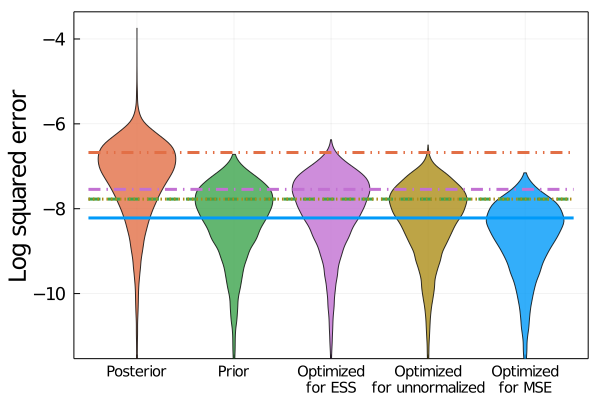

In [14]:
@time p = make_violin_plot(target_f_dict["95pct_CI"], true_p1s, proposal_names, num_trials = 10000)

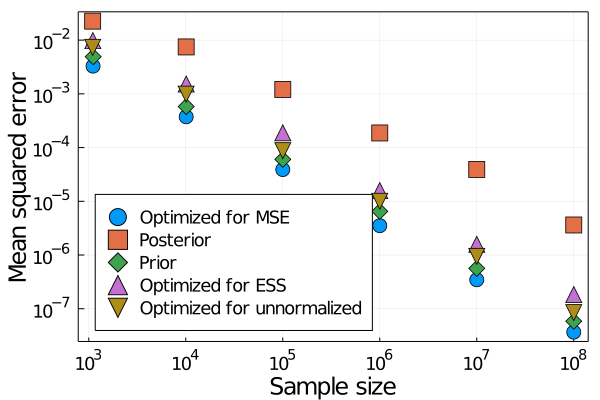

In [15]:
absolute_plot, relative_plot, errors = make_mse_plot_pair(target_f_dict["second_moment"], true_p1s, proposal_names, num_trials = 1000)
plot(absolute_plot)


In [16]:
function save_all_plots(target_f_dict; num_trials = 100, proposal_names = proposal_names, file_prefix = "")
    save_path = "./"
    for target_f_name in keys(target_f_dict)
        absolute_plot, relative_plot, errors = make_mse_plot_pair(target_f_dict[target_f_name], true_p1s, proposal_names, num_trials = num_trials)
        
        absolute_plot_filename = "discrete_gaussian_absolute_mse_"*target_f_name
        savefig(absolute_plot, save_path*file_prefix*absolute_plot_filename*".pdf")
        relative_plot_filename = "discrete_gaussian_relative_mse_"*target_f_name
        savefig(relative_plot, save_path*file_prefix*relative_plot_filename*".pdf")
        
        optimized_relative_ns = optimal_ni_fractions(true_p1s, target_f = target_f_dict[target_f_name])
        plot(thetas, optimized_relative_ns./sum(optimized_relative_ns), label = nothing,
            ylim = [0, 4/length(true_p1s)],
            ylabel = "q(θ)",
            xlabel = "θ",
            linewidth = 4,
            framestyle = :box,
            yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
            xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
        )
        savefig(save_path*file_prefix*"discrete_gaussian_optimal_distribution_"*target_f_name*".pdf")
        
        error_violin_plot = make_violin_plot(target_f_dict[target_f_name], true_p1s, proposal_names, num_trials = num_trials)
        violin_plot_filename = "discrete_gaussian_violin_"*target_f_name
        savefig(error_violin_plot, save_path*file_prefix*violin_plot_filename*".pdf")
        
    end
end

save_all_plots (generic function with 1 method)

In [17]:
@time save_all_plots(target_f_dict,
    num_trials = 10000,
    proposal_names = ["Posterior", "Prior", "Optimized for ESS", "Optimized for unnormalized"],)

 80.506829 seconds (691.80 M allocations: 218.893 GiB, 26.14% gc time)


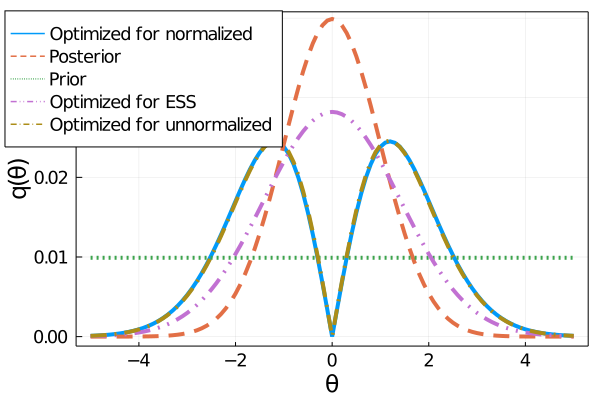

In [18]:
optimized_relative_ns = optimal_ni_fractions(true_p1s, target_f = target_f_dict["posterior"])

p = plot(thetas, optimized_relative_ns./sum(optimized_relative_ns),
    label = "Optimized for normalized",
    ylim = [0, 4/length(true_p1s)],
    ylabel = "q(θ)",
    xlabel = "θ",
    linewidth = 4,
    legend = (-0.05, 0.935),
    yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
    xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
    framestyle = :box,)

linestyles = [:dash, :dot, :dashdotdot, :dashdot]
for (label, style) in zip(proposal_names, linestyles)
    plot!(thetas, normalize(relative_ns(true_p1s, label), 1),
        label = label,
        linewidth = 4,
        linestyle = style,
    )
end


plot(p)